In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('..')
import random, math, os
import pyzx as zx
from fractions import Fraction
from pyzx.phasepoly import circuit_phase_polynomial_blocks, optimize_block
import numpy as np
%config InlineBackend.figure_format = 'svg'
zx.quantomatic.quantomatic_location = r'C:\Users\John\Desktop\scala.jar'

Circuit mod5_4_before on 5 qubits with 71 gates.
        28 is the T-count
        43 Cliffords among which 
        28 2-qubit gates and 14 Hadamard gates.
8


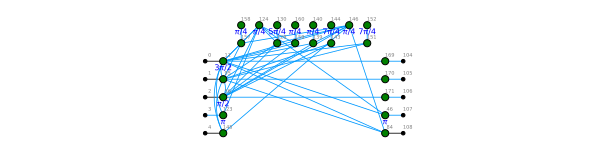

In [5]:
#g = zx.generate.identity(1,2)
#g = zx.quantomatic.edit_graph(g)
#circ_name = r'../circuits/toobig/hwb12.qc'
circ_name = r'../circuits/Fast/mod5_4_before'
c_orig = zx.Circuit.load(circ_name).to_basic_gates()
print(c_orig.stats())
g = c_orig.to_graph()
#g = zx.generate.cliffordT(4,100, p_t=0.2)
zx.simplify.full_reduce(g,quiet=True)
g.normalise()
print(zx.tcount(g))
zx.draw(g,labels=True)

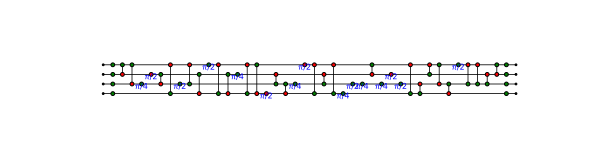

In [40]:
circ = zx.generate.cliffordT(4, 40, p_t=0.2,p_cnot=0.5)
zx.draw(circ)

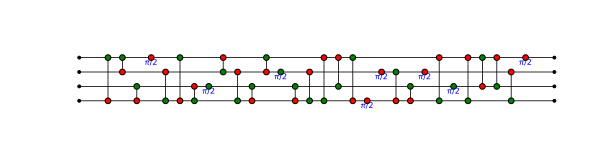

In [31]:
zx.simplify.id_simp(circ,quiet=True)
zx.draw(circ)

In [32]:
print(zx.drawing.to_tikz(circ))


\begin{tikzpicture}
    \begin{pgfonlayer}{nodelayer}
        \node [style=none] (0) at (0.00, 0.00) {};
        \node [style=none] (1) at (0.00, -1.00) {};
        \node [style=none] (2) at (0.00, -2.00) {};
        \node [style=none] (3) at (0.00, -3.00) {};
        \node [style=Z dot] (8) at (2.00, 0.00) {};
        \node [style=X dot] (9) at (2.00, -3.00) {};
        \node [style=Z dot] (10) at (3.00, 0.00) {};
        \node [style=X dot] (11) at (3.00, -1.00) {};
        \node [style=Z dot] (12) at (4.00, -2.00) {};
        \node [style=X dot] (13) at (4.00, -3.00) {};
        \node [style=X phase dot] (14) at (5.00, 0.00) {$\frac{\pi}{2}$};
        \node [style=Z dot] (15) at (6.00, -3.00) {};
        \node [style=X dot] (16) at (6.00, -1.00) {};
        \node [style=Z dot] (17) at (7.00, 0.00) {};
        \node [style=X dot] (18) at (7.00, -3.00) {};
        \node [style=Z dot] (19) at (8.00, -3.00) {};
        \node [style=X dot] (20) at (8.00, -2.00) {};
        \node [style=

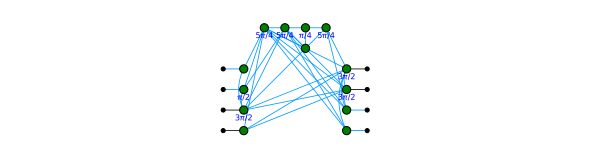

In [43]:
g = circ.copy()
zx.simplify.full_reduce(g)
g.normalise()
zx.draw(g)

In [42]:
print(zx.drawing.to_tikz(g))


\begin{tikzpicture}
    \begin{pgfonlayer}{nodelayer}
        \node [style=none] (0) at (0.00, 0.00) {};
        \node [style=none] (1) at (0.00, -1.00) {};
        \node [style=none] (2) at (0.00, -2.00) {};
        \node [style=none] (3) at (0.00, -3.00) {};
        \node [style=Z phase dot] (9) at (1.00, -1.00) {$\frac{\pi}{2}$};
        \node [style=Z phase dot] (12) at (2.00, -2.00) {$\frac{7\pi}{4}$};
        \node [style=Z phase dot] (14) at (3.00, -1.00) {$\frac{5\pi}{4}$};
        \node [style=Z dot] (15) at (3.00, -2.00) {};
        \node [style=Z dot] (17) at (1.00, 0.00) {};
        \node [style=Z phase dot] (18) at (4.00, -2.00) {$\frac{\pi}{4}$};
        \node [style=Z phase dot] (22) at (1.00, -3.00) {$\frac{3\pi}{2}$};
        \node [style=Z phase dot] (24) at (1.00, -2.00) {$\frac{3\pi}{2}$};
        \node [style=Z dot] (39) at (6.00, -1.00) {};
        \node [style=Z phase dot] (40) at (5.00, -3.00) {$\frac{5\pi}{4}$};
        \node [style=Z dot] (57) at (6.00, -2.00

In [161]:
from pyzx.circuit import ZPhase
from pyzx.linalg import Mat2
from pyzx.todd import todd_iter, MultiLinearPoly
#zx.todd.TOPT_LOCATION = os.path.expanduser("~/projects/pyzx/TOpt")
zx.todd.USE_REED_MULLER = False

def todd_on_graph(g):
    gadgets = {}
    t_nodes = []
    for v in g.vertices():
        if v not in g.inputs and v not in g.outputs and len(list(g.neighbours(v)))==1:
            if g.phase(v) != 0 and g.phase(v).denominator != 4: continue
            n = list(g.neighbours(v))[0]
            tgts = frozenset(set(g.neighbours(n)).difference({v}))
            gadgets[tgts] = (n,v)
        if g.phase(v) != 0 and g.phase(v).denominator == 4:
            t_nodes.append(v)
    
    if not gadgets:
        print("No phase gadgets found")
        return
    variables = set()
    for par in gadgets.keys():
        variables.update(par)
    
    for v in variables:
        if v in t_nodes:
            gadgets[frozenset({v})] = (v,v)
    
    targets = list(variables)
    n = len(targets)

    cols = []
    for par, (_,v) in gadgets.items():
        col = [0]*n
        for t in par:
            col[targets.index(t)] = 1
        phase = g.phase(v)
        for i in range(phase.numerator): cols.append(col)
        #cols.append(col)
    parmatrix = Mat2(cols).transpose()
    print(parmatrix.rows(), parmatrix.cols())
    #print(parmatrix)
    m2 = todd_iter(parmatrix)
    print(m2.rows(), m2.cols())
    
    newgadgets = []
    phases = dict()
    for col in m2.transpose().data:
        if sum(col) == 1:
            i = next(i for i,a in enumerate(col) if a)
            v = targets[i]
            if v in t_nodes:
                phases[v] = Fraction(1,4)
            else:
                phases[v] = g.phase(v) + Fraction(1,4)
        else:
            newgadgets.append(frozenset([targets[i] for i,a in enumerate(col) if a]))
    
    p = zx.todd.MultiLinearPoly()
    p.add_par_matrix(parmatrix,False)
    p.add_par_matrix(m2,True)
    correction = p.to_clifford()
    add_czs = {}
    for clif in correction:
        if isinstance(clif, ZPhase):
            v = targets[clif.target]
            if v in phases:
                phases[v] += clif.phase
            else:
                if v in t_nodes:
                    phases[v] = clif.phase
                else:
                    phases[v] = g.phase(v) + clif.phase
        elif clif.name == 'CZ':
            v1,v2 = targets[clif.control], targets[clif.target]
            add_czs[(v1,v2)] = (0,1)
    
    for v in targets:
        if v in phases:
            g.set_phase(v, phases[v])
        else:
            if v in t_nodes:
                g.set_phase(v, 0)
    g.add_edge_table(add_czs)
    
    rs = g.rows()
    positions = set()
    for gadget, (n,v) in gadgets.items():
        if len(gadget) == 1: continue # T-node
        if gadget in newgadgets:
            positions.add(rs[v])
            g.set_phase(v, Fraction(1,4))
            newgadgets.remove(gadget)
        else:
            g.remove_vertices((n,v))
    
    edges = []
    for par in newgadgets:
        pos = sum(rs[t] for t in par)/len(par) + 0.5
        while pos in positions: pos += 0.5
        n = g.add_vertex(1, -1, pos)
        v = g.add_vertex(1, -2, pos, phase=Fraction(1,4))
        edges.append((n,v))
        positions.add(pos)
        for t in par: edges.append((n,t))
    g.add_edges(edges, 2)
    

g2 = g.copy()
#display(zx.draw(g2,labels=True))
todd_on_graph(g2)
zx.full_reduce(g2)
g2.normalise()
print(zx.tcount(g2))
todd_on_graph(g2)
zx.full_reduce(g2)
g2.normalise()
print(zx.tcount(g2))
#zx.draw(g2)

11 135
11 17
17
8 37
8 17
17


In [162]:
# todd_on_graph(g2)
# zx.full_reduce(g2)
# g2.normalise()
zx.tcount(g2)

17

14
14
14


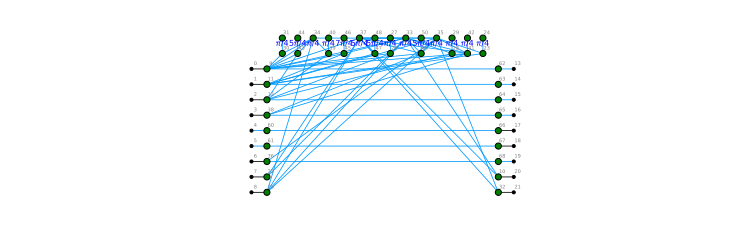

In [163]:
g3 = g2.copy()
try: c2 = zx.extract.streaming_extract(g3,allow_ancillae=True,quiet=True)
except: pass
print(zx.tcount(g3))
g3 = g3.adjoint()
try: c2 = zx.extract.streaming_extract(g3,allow_ancillae=True,quiet=True)
except: pass
zx.simplify.id_simp(g3, quiet=True)
g3.normalise()
print(zx.tcount(g3))
g3 = g3.adjoint()
try: c2 = zx.extract.streaming_extract(g3,allow_ancillae=True,quiet=True)
except: pass
zx.simplify.id_simp(g3, quiet=True)
g3.normalise()
print(zx.tcount(g3))
#zx.simplify.id_simp(g3, quiet=True)
zx.draw(g3,figsize=(10,3),labels=True)

33
[41, 45, 49, 26, 28]
found match!


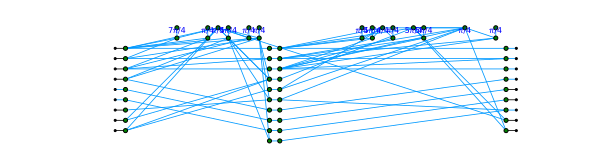

In [164]:
g = g3.copy()
q = len(g.inputs)
left = [v for v in g.vertices() if g.row(v) == 1]
gadgets = {}
gadget_reverse = {}
for v in g.vertices():
    if v not in g.inputs and v not in g.outputs and len(list(g.neighbours(v)))==1:
        if g.phase(v) != 0 and g.phase(v).denominator != 4: continue
        n = list(g.neighbours(v))[0]
        gadgets[n] = v
        gadget_reverse[v] = n
#extra = [36, 33, 38, 37]
left = left
right = set()
for v in left: right.update(w for w in g.neighbours(v) if g.row(w)>1)
nodes = list(right.difference(gadgets))
gadgets_conn = list(right.intersection(gadgets))
#print(nodes)
#print(gadgets_conn)
right = list(right)
for w in nodes:
    right.remove(w)
    right.append(w)
#m = zx.extract.bi_adj(g, right, left)
for w in nodes:
    m = zx.extract.bi_adj(g, right, left+[w])
    if m.rank() > q:
        print(w)
        r = right.copy()
        r.remove(w)
        conn = []
        for gadget in gadgets_conn:
            if g.connected(gadget, w):
                conn.append(gadget)
                r.remove(gadget)
        print(conn)
        if len(conn) < 3: continue
        m = zx.extract.bi_adj(g, r, left+conn+[w])
        if m.rank() <= q+1:
            print("found match!")
            break
#m2 = zx.extract.bi_adj(g, r, left+conn+[w])
#print(m2.rank())
new_left = left+conn+[w]
for v in g.vertices():
    if v not in new_left:
        if v in gadget_reverse and gadget_reverse[v] in new_left: continue
        row = g.row(v)
        if row > 1:
            g.set_row(v, row+20)
new_right = zx.extract.cut_edges(g,new_left, r)
zx.draw(g)

In [27]:
g4 = g3.copy()
#for e in g4.edges(): g4.set_edge_type(e, 1)
g4 = zx.quantomatic.edit_graph(g4)

Opening Quantomatic...
Done


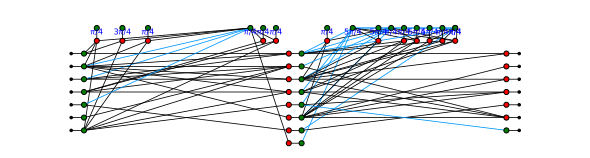

In [46]:
g4 = g.copy()
zx.to_rg(g4,select=lambda v: all(g4.edge_type(e)==2 for e in g4.incident_edges(v)) and g4.phase(v)==0)
zx.draw(g4)

In [183]:
zx.is_unitary(g4)

True

In [47]:
g6 = zx.quantomatic.edit_graph(g4)

Opening Quantomatic...
Done


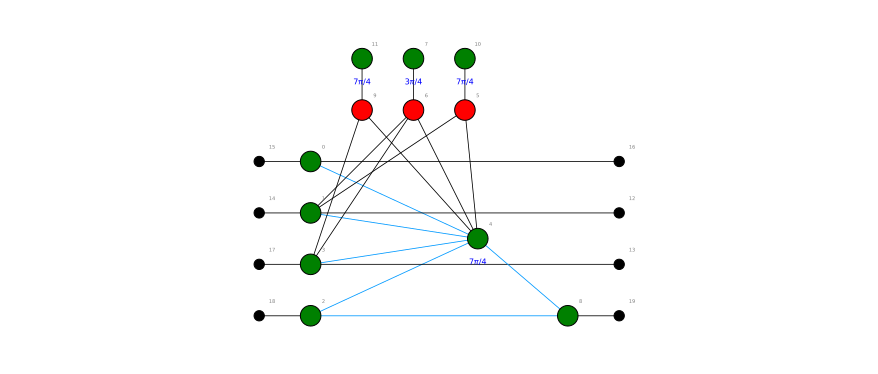

In [153]:
zx.draw(g6,figsize=(12,5), labels=True)

True


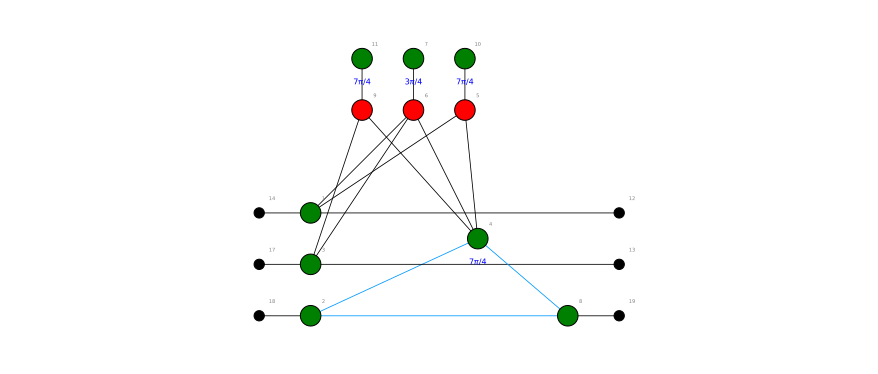

In [172]:
g7 = g6.copy()
# g7.remove_vertices([18,2,8,19])
# g7.inputs.remove(18)
# g7.outputs.remove(19)
g7.remove_vertices([15,0,16])
g7.inputs.remove(15)
g7.outputs.remove(16)

# targets = [11,7,10,4]
# options = [Fraction(1,4),Fraction(3,4),Fraction(5,4),Fraction(7,4)]
# for a in options:
#     g7.set_phase(targets[0],a)
#     for b in options:
#         g7.set_phase(targets[1],b)
#         for c in options:
#             g7.set_phase(targets[2],c)
#             for d in options:
#                 g7.set_phase(targets[3],d)
#                 print(a,b,c,d, (a+b+c+d).denominator, zx.is_unitary(g7))
#for v in targets: g7.set_phase(v,Fraction(1,4))
#g7.set_phase(7,Fraction(7,4))
#g7.set_phase(7,Fraction(3,4))
g7.remove_edges([(1,4),(3,4)])
#g7.set_edge_type((2,8),1)
#g7.normalise()
print(zx.is_unitary(g7))
zx.draw(g7, figsize=(12,5),labels=True)

In [173]:
g8 = g7.copy()
g8.normalise()
#g8.compose(g8.adjoint())
#zx.full_reduce(g8)
#zx.draw(g8)
#g8.set_qubit(2, 0.5)
t = g8.to_tensor()
t/t.flatten()[0]

array([[[[[[ 1.+0.j, -0.+0.j],
           [-0.+0.j, -1.+0.j]],

          [[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]]],


         [[[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]],

          [[-0.-0.j,  0.+1.j],
           [ 0.+1.j,  0.+0.j]]]],



        [[[[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]],

          [[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]]],


         [[[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]],

          [[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]]]]],




       [[[[[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]],

          [[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]]],


         [[[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]],

          [[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]]]],



        [[[[-0.-0.j,  0.+1.j],
           [ 0.+1.j,  0.+0.j]],

          [[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]]],


         [[[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]],

          [[-0.-0.

In [175]:
a = zx.Circuit(3)
a.add_gate("NOT",0)
a.add_gate("NOT",1)
a.add_gate("Z",0)
a.add_gate("Z",1)
a.add_gate("S",2)
a.add_gate("HAD",2)
a.add_gate("NOT",2)
a.add_gate("Z",2)
a.add_gate("CCZ",0,1,2)
a.add_gate("NOT",2)
a.add_gate("HAD",2)
a.add_gate("S",2)
a.add_gate("NOT",1)
a.add_gate("NOT",0)
t2 = a.to_tensor()
zx.compare_tensors(t,t2)

True

In [141]:
a = zx.Circuit(3)
a.add_gate("CNOT",0, 2)
a.add_gate("InitAncilla",'a')
a.add_gate("HAD", 'a')
a.add_gate("CNOT", 2, 'a')
a.add_gate("CNOT", 1, 'a')
a.add_gate("T", 0, adjoint=True)
a.add_gate("T", 1, adjoint=True)
a.add_gate("T", 2, adjoint=False)
a.add_gate("T", 'a', adjoint=True)
a.add_gate("CNOT", 1, 'a')
a.add_gate("CNOT", 2, 'a')
a.add_gate("CNOT",0, 2)
a.add_gate("CNOT",1, 0)
a.add_gate("CNOT",2, 1)
a.add_gate("T", 0, adjoint=False)
a.add_gate("T", 1, adjoint=False)
a.add_gate("T", 2, adjoint=True)
a.add_gate("CNOT",2, 1)
a.add_gate("CNOT",1, 0)
a.add_gate("HAD", 'a')
a.add_gate("PostSelect", 'a')

b = zx.Circuit(3)
b.add_gate("CCZ",0,1,2)
zx.compare_tensors(a,b)
#t2/t2.flatten()[0]
# b = a.to_graph()
# b.inputs, b.outputs

True

In [142]:
a = zx.generate.identity(1)
a = zx.quantomatic.edit_graph(a)

Opening Quantomatic...
Done


In [149]:
a.auto_detect_inputs()
a.normalise()
a.to_tensor()

array([[0.25-0.25j, 0.25-0.25j],
       [0.25-0.25j, 0.25-0.25j]])

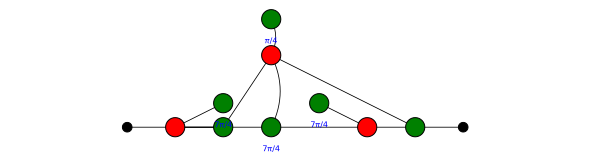

In [152]:
zx.draw(a)

In [150]:
b = zx.generate.identity(1)
b = zx.quantomatic.edit_graph(b)
b.auto_detect_inputs()
b.normalise()
b.to_tensor()

Opening Quantomatic...
Done


array([[1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j]])

In [151]:
zx.compare_tensors(a,b)

True

In [110]:
zx.generate.identity(2).to_tensor()

array([[[[1., 0.],
         [0., 1.]],

        [[0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[1., 0.],
         [0., 1.]]]])

In [87]:
s = zx.io.graph_to_json(g7)
fname = r'..\circuits\horrible_unitary_small.qgraph'
with open(fname, 'w') as f:
    f.write(s)


In [22]:
import subprocess
import os
s = subprocess.check_output(["../TOpt", "gsm","../testmatrix.gsm"]).decode()

In [4]:
g2 = g.copy()
zx.simplify.to_rg(g2)
zx.quantomatic.edit_graph(g2)

Opening Quantomatic...
Done


Graph(13 vertices, 21 edges)

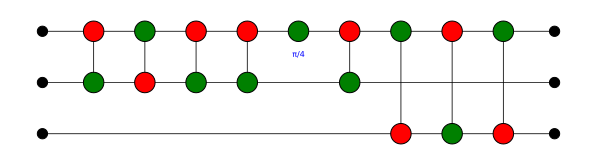

In [220]:
c = zx.Circuit(3)
qubits = c.qubits
c.add_gate("SWAP",1,0)
c.add_gate("ParityPhase", Fraction(1,4),1,0)
c.add_gate("SWAP",0,2)
zx.draw(c)

1.

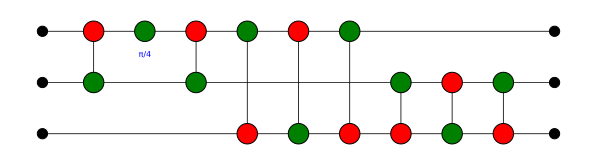

In [228]:
o = zx.optimize.Optimizer(c.to_basic_gates())
circuit, correction = o.parse_circuit(separate_correction=True, quiet=False)
zx.draw(zx.optimize.phase_block_optimize(c.to_basic_gates()))

In [225]:
correction

[SWAP(0,2), SWAP(1,2)]

In [11]:
from pyzx.circuit import SWAP
qubits = 3
permutation = {i:i for i in range(qubits)}
correction = [SWAP(0,1),SWAP(0,2)]
for g in correction:
    if g.name == 'SWAP':
        a = permutation[g.control]
        b = permutation[g.target]
        permutation[g.control] = b
        permutation[g.target] = a
    elif g.name == 'NOT':
        nots.append(g)
    else:
        raise TypeError("Illegal correction {}".format(str(g)))

permutation = {v:k for k,v in permutation.items()}
zx.extract.permutation_as_swaps(permutation)
#permutation

[(0, 2), (1, 2)]

In [227]:
permutation = {i:i for i in range(qubits)}
nots = []
for g in correction:
    if g.name == 'SWAP':
        a = permutation[g.control]
        b = permutation[g.target]
        permutation[g.control] = b
        permutation[g.target] = a
    elif g.name == 'NOT':
        nots.append(g)
    else:
        raise TypeError("Illegal correction {}".format(str(g)))
permutation = {v:k for k,v in permutation.items()}
permutation

{2: 0, 0: 1, 1: 2}

In [198]:
phase_poly, parity_polys = zx.todd.phase_gates_to_poly(c.to_basic_gates().gates, c.qubits)
phase_poly, parity_polys

(x0@x1, [x2, x0, x1])

In [199]:
from pyzx.phasepoly import parity_network
m = phase_poly.to_par_matrix()
newgates = []
parities = []
for col in m.transpose().data:
    #if sum(col) == 1:
    #    newgates.append(T(next(i for i in range(qubits) if col[i])))
    #else:
    parities.append(col)

cnots = parity_network(c.qubits, parities)
parities

[[1, 1, 0]]

In [164]:
cnots

[CNOT(1,0)]

In [200]:
m = zx.Mat2.id(c.qubits)
for cnot in cnots:
    m.row_add(cnot.control, cnot.target)
m

[ 1  1  0 ]
[ 0  1  0 ]
[ 0  0  1 ]

In [166]:
m.to_cnots()

[CNOT(0,1)]

In [201]:
data = []
for p in parity_polys:
    l = [int(i in p.par) for i in range(c.qubits)]
    data.append(l)

m2 = zx.Mat2(data)
m2

[ 0  0  1 ]
[ 1  0  0 ]
[ 0  1  0 ]

In [202]:
target_matrix = zx.Mat2(data) * m.inverse()
target_matrix

[ 0  0  1 ]
[ 1  1  0 ]
[ 0  1  0 ]

In [207]:
perm = zx.linalg.column_optimal_swap(target_matrix.transpose())
swaps = zx.extract.permutation_as_swaps(perm)
m2 = target_matrix.copy()
for a,b in swaps:
    m2.row_swap(a,b)

inv = {v:k for k,v in perm.items()}
m2

[ 1  1  0 ]
[ 0  1  0 ]
[ 0  0  1 ]

In [208]:
trueswaps = zx.extract.permutation_as_swaps(inv)
trueswaps

[(0, 2), (1, 2)]

In [194]:
perm, swaps

({3: 0, 0: 1, 1: 2, 2: 3}, [(0, 3), (1, 3), (2, 3)])

In [205]:
gates = m2.to_cnots(optimize=True)
gates

[CNOT(0,1)]

In [56]:
def generate_parities(targets):
    parities = set()
    for i in range(4):
        a = targets[i]
        parities.add(frozenset([a]))
        for j in range(i+1,4):
            b = targets[j]
            parities.add(frozenset([a,b]))
            for k in range(j+1,4):
                c = targets[k]
                parities.add(frozenset([a,b,c]))
                for l in range(k+1,4):
                    d = targets[l]
                    parities.add(frozenset([a,b,c,d]))
    return parities

s1 = generate_parities([1,2,3,4])
s2 = generate_parities([1,3,4,5])
s3 = generate_parities([1,2,4,5])
#s5 = generate_parities([1,2,3,5])
s1.symmetric_difference(s2).symmetric_difference(s3)#.symmetric_difference(s4))#.symmetric_difference(s5)

{frozenset({1, 2, 3, 4}),
 frozenset({3, 5}),
 frozenset({1, 3, 5}),
 frozenset({2, 3}),
 frozenset({4}),
 frozenset({2, 3, 4}),
 frozenset({2, 5}),
 frozenset({1}),
 frozenset({1, 2, 4, 5}),
 frozenset({1, 2, 3}),
 frozenset({3, 4, 5}),
 frozenset({1, 4}),
 frozenset({1, 3, 4, 5}),
 frozenset({1, 2, 5}),
 frozenset({2, 4, 5})}

In [ ]:
[ 1  1  0  0  1  0  1  0 ]
[ 1  1  1  0  0  1  0  0 ]
[ 0  1  0  1  1  1  0  0 ]
[ 1  0  0  0  1  1  0  1 ]
[ 1  0  1  1  1  0  0  0 ]

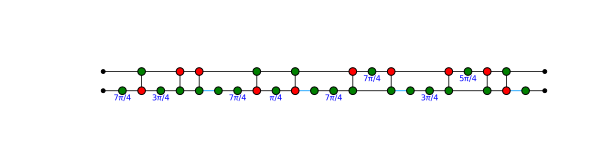

In [5]:
g = zx.generate.circuit_identity_commuting_controls(Fraction(1,4),Fraction(1,4))
zx.simplify.full_reduce(g)
c = zx.extract.streaming_extract(g).to_basic_gates()
c2, blocks = circuit_phase_polynomial_blocks(c,optimize=True)
c3, blocks = circuit_phase_polynomial_blocks(c2,optimize=True)
zx.draw(c3)

[]


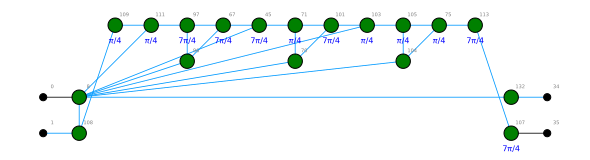

In [39]:
#c = generate_identity(Fraction(5,4),Fraction(7,4))
g = c.to_graph()
zx.simplify.full_reduce(g)
zx.simplify.full_reduce(g)
# zx.simplify.gadgetize(g)
# edges = [(49,55),(55,49),(59,65),(65,59)]
# zx.simplify.pivot_simp(g,matchf=lambda e: e in edges)
# zx.simplify.id_simp(g)
m = zx.rules.match_gadgets_phasepoly(g)
print(m)
#print(alpha, beta, [g.phase(v).numerator for v in g.vertices() if g.phase(v) != 0 and g.phase(v).denominator!=1])
#zx.gadget_simp(g)
# zx.simplify.id_simp(g)
#zx.full_reduce(g)
g.normalise()
zx.draw(g,labels=True)

In [35]:
zx.compare_tensors(g.to_tensor(), zx.generate.identity(2).to_tensor())

True

In [31]:
zx.quantomatic.edit_graph(g)

Opening Quantomatic...
Done


Graph(18 vertices, 23 edges)

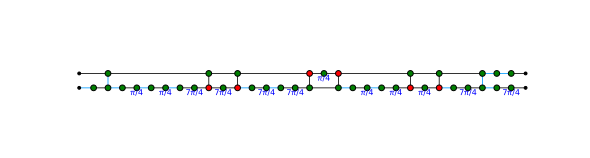

In [36]:
g2 = g.copy()
c2 = zx.extract.streaming_extract(g2)
zx.draw(c2.to_graph())

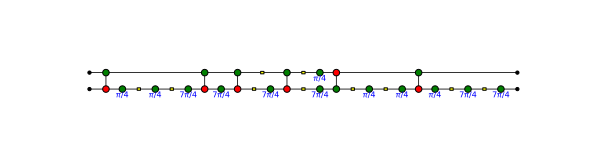

In [37]:
c3, blocks = circuit_phase_polynomial_blocks(c2.to_basic_gates(),optimize=True)
c4, blocks = circuit_phase_polynomial_blocks(c3,optimize=True)
g = c4.to_graph()
zx.simplify.id_simp(g,quiet=True)
zx.draw(g,h_edge_draw='box')

In [42]:
zx.compare_tensors(c4,zx.identity(2))

True

In [156]:
g = zx.generate.identity(1,3)
g = zx.quantomatic.edit_graph(g)

Opening Quantomatic...
Done


In [21]:
a = zx.Circuit(2)
a.add_gate("CZ",0,1)
a.add_gate("CNOT",0,1)
b = zx.Circuit(2)
b.add_gate("S",0)
b.add_gate("S",1)
b.add_gate("CNOT",0,1)
b.add_gate("S",1, adjoint=True)
zx.compare_tensors(a,b)

True

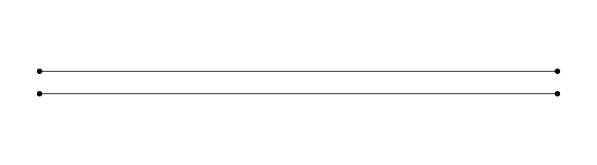

In [49]:
alpha = Fraction(3,5)
beta= Fraction(5,7)

c = zx.Circuit(2)
c.add_gate("XPhase", 1, alpha)
c.add_gate("ZPhase", 1, beta)
c.add_gate("XPhase", 1, alpha)
c.add_gate("NOT", 0)
c.add_gate("NOT", 1)
c.add_gate("CNOT",0,1)
c.add_gate("XPhase", 1, -alpha)
c.add_gate("NOT", 1)
c.add_gate("ZPhase", 1, -beta)
c.add_gate("XPhase", 1, -alpha)
c.add_gate("CNOT",0,1)
c.add_gate("NOT", 0)
c.add_gate("NOT", 1)
c.add_circuit(c)
g = c.to_graph()
zx.full_reduce(g)
zx.draw(g)

In [52]:
a = 1
y= 0.5
x = 0.4
b = 1.5
c = 1.2

m = np.mat([[a,y,x],[y,b,0],[x,0,c]])
#np.linalg.eigvals(m)
m
t = scipy.linalg.cholesky(m)
m

matrix([[1. , 0.5, 0.4],
        [0.5, 1.5, 0. ],
        [0.4, 0. , 1.2]])

In [54]:
np.matmul(m,m2) - np.matmul(m2,m)

matrix([[ 0.  , -0.35, -0.06],
        [ 0.35,  0.  ,  0.05],
        [ 0.06, -0.05,  0.  ]])

In [53]:
a = 1.2
y= 0.5
x = 0.5
b = 1.0
c = 1.3
m2 = np.mat([[a,y,x],[y,b,0],[x,0,c]])
u = scipy.linalg.cholesky(m2)

In [57]:
def clan(a,b):
    at = np.copy(a)
    for i in range(at.shape[0]):
        at[i,i] = at[i,i]/2.0
        for j in range(i+1,at.shape[1]):
            at[i,j] = 0
    return at.T
    return np.matmul(at.T,b) + np.matmul(b,at)

mt = clan(m,m2)
m2t = clan(m2,m2)
np.matmul(mt,m2t) - np.matmul(m2t,mt)

array([[ 0.   , -0.175, -0.03 ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ]])

In [41]:
m.shape

(3, 3)

In [39]:
np.matmul(np.matmul(t.T,u.T),np.matmul(u,t))

array([[1.2       , 1.15901699, 0.8925533 ],
       [1.15901699, 2.10901699, 0.46988345],
       [0.8925533 , 0.46988345, 1.86444264]])

In [12]:
import scipy.linalg

sq = scipy.linalg.sqrtm(m)

In [25]:
d, l, u = scipy.linalg.lu(m)
print(l)
print(u)
d = np.diag([u[0,0],u[1,1],u[2,2]])
up = np.matmul(np.linalg.inv(d), u)
up

[[ 1.    0.    0.  ]
 [ 0.5   1.    0.  ]
 [ 0.4  -0.16  1.  ]]
[[ 1.     0.5    0.4  ]
 [ 0.     1.25  -0.2  ]
 [ 0.     0.     1.008]]


array([[ 1.  ,  0.5 ,  0.4 ],
       [ 0.  ,  1.  , -0.16],
       [ 0.  ,  0.  ,  1.  ]])

In [33]:
msq = scipy.linalg.sqrtm(d)
t = np.matmul(l, msq)
t2 = np.matmul(msq, up)
#np.matmul(t,np.matmul(m2,t2))
t

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.5       ,  1.11803399,  0.        ],
       [ 0.4       , -0.17888544,  1.00399203]])

In [32]:
scipy.linalg.cholesky(m)

array([[ 1.        ,  0.5       ,  0.4       ],
       [ 0.        ,  1.11803399, -0.17888544],
       [ 0.        ,  0.        ,  1.00399203]])